# ann-project

5조
한수호, 강구현, 김민규, 홍준기

# Setup

In [1]:
from models.simple_cnn import CNNModel
from models.residual import ResModel
from models.resnet50 import ResNetModel
from models.lenet import LeNetModel
from keras import callbacks, optimizers, layers, losses
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import seaborn as sns
import random
from IPython.display import display
from sklearn.metrics import confusion_matrix, f1_score
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

2024-06-05 15:14:42.281468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 15:14:42.281508: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 15:14:42.281545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 15:14:42.287784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 15:14:42.991003: W tensorflow/compiler/

In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [3]:
from datetime import datetime
result_path = './results'
_time = datetime.strftime(datetime.today(), '%Y-%m-%d_%H-%M-%S')

dataset

In [4]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-byclass-test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

x_train = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 62)
y_test_bymerge = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 62)

y_train_int = train_data.iloc[:, 0].to_numpy()
y_test_int = test_data.iloc[:, 0].to_numpy()

_, _, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
x_train, x_valid, y_train_int, y_valid_int = train_test_split(x_train, y_train_int, test_size=0.1, random_state=42)

x_train_resized = tf.image.resize(x_train, [32, 32])
x_valid_resized = tf.image.resize(x_valid, [32, 32])
x_test_resized = tf.image.resize(x_test, [32, 32])

2024-06-05 15:15:10.487688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 15:15:10.515374: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 15:15:10.515700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

checkpoints

In [5]:
def create_callbacks(model_name):
    current_time = int(time.time())
    checkpoint_path = f"./checkpoints/checkpoints_{model_name}/weights.{current_time}.hdf5"
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                             min_delta=0.0001, restore_best_weights=True)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
    checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    return [early_stopping, reduce_lr, checkpoint]


callbacks_lenet = create_callbacks('lenet')
callbacks_resnet = create_callbacks('resnet')
callbacks_ours_1 = create_callbacks('ours_1')
callbacks_ours_2 = create_callbacks('ours_2')
callbacks_final = create_callbacks('final')
result_path = './results'

test results

In [6]:
def save_results(results_df):
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    results_df.to_csv(os.path.join(result_path, f'result_{_time}.csv'), index=False)

saving history

In [7]:
def save_history(histories, filename):
    with open(os.path.join(result_path, filename), 'w') as f:
        json.dump(histories, f)

# 1. baseline과 our 모델 비교

In [ ]:
# Initialize models
lenet_model = LeNetModel()
resnet_model = ResNetModel()
our_model_1 = CNNModel()
our_model_2res = ResModel()

# Compile models
lenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = []
training_time = []

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
start_time = time.time()
history.append(lenet_model.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_lenet]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(resnet_model.train(x_train_resized, y_train_int, validation_data=(x_valid_resized,
               y_valid_int), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_resnet]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(our_model_1.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_1]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
start_time = time.time()
history.append(our_model_2res.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int),
               epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[callbacks_ours_2]))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
loss_lenet, acc_lenet = lenet_model.evaluate(x_test, y_test_int)
loss_resnet, acc_resnet = resnet_model.evaluate(x_test_resized, y_test_int)
loss_our1, acc_our1 = our_model_1.evaluate(x_test, y_test_int)
loss_our2, acc_our2 = our_model_2res.evaluate(x_test, y_test_int)

In [ ]:
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model(CNN)", "Our Model(Residual)"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_{_time}.csv', index=False)

In [ ]:
models = ["lenet-5", "resnet-50", "our_model_cnn", "our_model_residual"]
for model_name, h in zip(models, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_{model_name}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold"]

plt.figure(figsize=(10, 5))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()
save_history(history, f'history_activation_{_time}.pkl')

In [ ]:
training_time.append("")
results = {
    "Model": ["LeNet-5", "ResNet-50", "Our Model", "Wavemix-256[6]"],
    "Loss": [loss_lenet, loss_resnet, loss_our1, loss_our2, 0],
    "Accuracy": [acc_lenet, acc_resnet, acc_our1, acc_our2, 0.8842],
    "Training Time": training_time
}
results_df = pd.DataFrame(results)

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

# 2. Experiment

## 2.1. Optimizer

In [ ]:
optimizers_list = [
    optimizers.SGD(learning_rate=0.001, momentum=0.9),
    optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
    optimizers.Adagrad(learning_rate=0.001),
    optimizers.RMSprop(learning_rate=0.001, rho=0.9),
    optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
]

In [ ]:
history = []
results = {'Optimizer': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
def _train_opt(x_train, y_train, validation_data, optimizer, activation_ftn='ReLU'):
    print(f"Start with {type(optimizer).__name__}")
    final_model = ResModel(num_classes=62, initial_filters=32,
                           dropout_rate=0.3, final_dropout_rate=0.6, activation=activation_ftn, num_residual_units=3)
    optimizer.build(final_model.model.trainable_variables)

    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Optimizer'].append(type(optimizer).__name__)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {type(optimizer).__name__}")

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
for optimizer in optimizers_list:
    _train_opt(x_train, y_train_int, (x_valid, y_valid_int), optimizer, activation_ftn='ReLU')

In [ ]:
results_df = pd.DataFrame(results)
save_results(results_df)
for optimizer, h in zip(optimizers_list, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_optimizer_{type(optimizer).__name__}_{_time}.json')

In [ ]:
plt.figure(figsize=(14, 6))

for i, h in enumerate(history):
    plt.subplot(1, 2, 1)
    plt.plot(h.history['accuracy'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(h.history['loss'], label=f'{type(optimizers_list[i]).__name__} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(5, 6))
    sns.barplot(x="Optimizer", y=metric, hue="Optimizer", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Optimizer')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_{_time}.png')
    plt.show()

## 2.2. Activation Function

In [ ]:
activations = {
    'relu': layers.ReLU(),
    'leaky_relu': layers.LeakyReLU(),
    'elu': layers.ELU(),
    'selu': layers.Activation('selu'),
    'sigmoid': layers.Activation('sigmoid'),
    'tanh': layers.Activation('tanh'),
    'softmax': layers.Activation('softmax'),
    'softplus': layers.Activation('softplus'),
    'softsign': layers.Activation('softsign'),
    'swish': layers.Activation('swish'),
    'gelu': layers.Activation('gelu')
}

In [ ]:
history = []
results = {'Activation Function': [], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
best_optimizer = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
activation_functions = ['relu', 'leaky_relu', 'elu', 'selu', 'sigmoid', 'tanh',
                        'softmax', 'softplus', 'softsign', 'swish', 'gelu']

In [ ]:
def _train_act(x_train, y_train, validation_data, optimizer, activation_ftn):
    print(f"Start with {activation_ftn}")

    activation_layer = activations.get(activation_ftn, layers.ReLU())

    final_model = ResModel(num_classes=62, initial_filters=32, dropout_rate=0.3,
                           final_dropout_rate=0.6, activation=activation_layer, num_residual_units=3)
    final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = final_model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                             batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = final_model.evaluate(x_test, y_test_int)
    results['Activation Function'].append(activation_ftn)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

    print(f"End with {activation_ftn}")

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
for ftn in activation_functions:
    _train_act(x_train, y_train_int, (x_valid, y_valid_int), optimizer=best_optimizer, activation_ftn=ftn)

In [ ]:
results_df = pd.DataFrame(results)
save_results(results_df)
for activation, h in zip(activation_functions, history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}  # Ensure values are float
    save_history(history_dict, f'history_activation_{activation}_{_time}.json')

In [ ]:
len(history)

In [ ]:
plt.figure(figsize=(14, 6))

for i in range(len(activation_functions)):
    plt.subplot(1, 2, 1)
    plt.plot(history[i].history['accuracy'], label=f'{activation_functions[i]} Train')
    plt.title('train accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history[i].history['loss'], label=f'{activation_functions[i]} Train')
    plt.title('train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

plt.tight_layout()
plt.savefig(f"{result_path}/result_activation_{_time}.png")
plt.show()

In [ ]:
display(results_df)

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Loss", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Loss"} Comparison')
plt.ylabel("Loss")
plt.xlabel('Activation Function')
plt.tight_layout()
plt.savefig(f'{result_path}/{"Loss".lower().replace(" ", "_")}_comparison_{_time}.png')

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Accuracy", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Accuracy"} Comparison')
plt.ylabel("Accuracy")
plt.xlabel('Activation Function')
plt.ylim([0.8, 1])
plt.tight_layout()
plt.savefig(f'{result_path}/{"Accuracy".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Activation Function", y="Training Time", hue="Activation Function",
            data=results_df, palette="viridis", legend=False)
plt.title(f'{"Training Time"} Comparison')
plt.ylabel("Training Time")
plt.xlabel('Activation Function')
plt.tight_layout()
plt.savefig(f'{result_path}/{"Training Time".lower().replace(" ", "_")}_comparison_{_time}.png')
plt.show()

## 2.3. The number of Residual Blocks

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('final')

In [ ]:
best_optimizer = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
best_activation = 'swish'

In [ ]:
our_model_1res = ResModel(num_residual_units=1, activation=best_activation)
our_model_2res = ResModel(num_residual_units=2, activation=best_activation)
our_model_3res = ResModel(num_residual_units=3, activation=best_activation)
our_model_4res = ResModel(num_residual_units=4, activation=best_activation)

In [ ]:
our_model_1res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_3res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_4res.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
def _train_blocks(model, x_train, y_train, validation_data):
    model.compile(optimizer=best_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
start_time = time.time()
_train_blocks(our_model_1res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)

start_time = time.time()
_train_blocks(our_model_2res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
_train_blocks(our_model_3res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)


start_time = time.time()
_train_blocks(our_model_4res, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)

In [ ]:
loss_our1res, acc_our1res = our_model_1res.evaluate(x_test, y_test_int)
loss_our2res, acc_our2res = our_model_2res.evaluate(x_test, y_test_int)
loss_our3res, acc_our3res = our_model_3res.evaluate(x_test, y_test_int)
loss_our4res, acc_our4res = our_model_4res.evaluate(x_test, y_test_int)

In [ ]:
results = {
    "Model": ["Our Model(Residual, 1 units)", "Our Model(Residual, 2 units)", "Our Model(Residual, 3 units)", "Our Model(Residual, 4 units)"],
    "Loss": [loss_our1res, loss_our2res, loss_our3res, loss_our4res],
    "Accuracy": [acc_our1res, acc_our2res, acc_our3res, acc_our4res],
    "Training Time": training_time
}

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_blocks_{_time}.csv', index=False)

In [ ]:
for i, h in zip(range(1, 5), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_block_{i}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Model"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_blocks_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Model", y=metric, hue="Model", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_blocks_{_time}.png')
    plt.show()

## 2.4. Learning Rate

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('lr')

In [ ]:
best_optimizer_1 = optimizers.legacy.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
best_optimizer_2 = optimizers.legacy.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
best_optimizer_3 = optimizers.legacy.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
best_optimizer_4 = optimizers.legacy.Nadam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999)
best_optimizer_5 = optimizers.legacy.Nadam(learning_rate=0.000001, beta_1=0.9, beta_2=0.999)
best_activation = 'swish'

In [ ]:
our_model_1lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_2lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_3lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_4lr = ResModel(num_residual_units=3, activation=best_activation)
our_model_5lr = ResModel(num_residual_units=3, activation=best_activation)

In [ ]:
our_model_1lr.compile(optimizer=best_optimizer_1, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_2lr.compile(optimizer=best_optimizer_2, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_3lr.compile(optimizer=best_optimizer_3, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_4lr.compile(optimizer=best_optimizer_4, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
our_model_5lr.compile(optimizer=best_optimizer_5, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
results = {'Learning Rate': ['1e-2', '1e-3', '1e-4', '1e-5', '1e-6'], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:


def _train_lr(model, optimizer, x_train, y_train, validation_data):
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
start_time = time.time()
_train_lr(our_model_1lr, best_optimizer_1, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_1')

start_time = time.time()
_train_lr(our_model_2lr, best_optimizer_2, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_2')


start_time = time.time()
_train_lr(our_model_3lr, best_optimizer_3, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_3')

start_time = time.time()
_train_lr(our_model_4lr, best_optimizer_4, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_4')

start_time = time.time()
_train_lr(our_model_5lr, best_optimizer_5, x_train, y_train_int, (x_valid, y_valid_int))
end_time = time.time()
training_time.append(end_time-start_time)
callbacks_final = create_callbacks('lr_5')

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_lr_{_time}.csv', index=False)

In [ ]:
for i, h in zip(range(1, 4), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_lr_{i}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_lr_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Learning Rate", y=metric, hue="Learning Rate", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Learning Rate')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_lr_{_time}.png')
    plt.show()

### 2.4.1. Detailed learning rate

In [ ]:
history = []
training_time = []

In [ ]:
callbacks_final = create_callbacks('lr')

In [ ]:
best_activation = 'swish'

In [ ]:
EPOCHS = 50
BATCH_SIZE = 500

In [ ]:
results = {'Learning Rate': ['1e−3', '9e−4', '8e−4', '7e−4', '6e−4',
                             '5e−4', '4e−4', '3e−4', '2e−4', '1e−4'], 'Loss': [], 'Accuracy': [], 'Training Time': []}

In [ ]:
def _train_lr(learning_rate, x_train, y_train, validation_data):
    model = ResModel(num_residual_units=3, activation=best_activation)
    _optimizer = optimizers.legacy.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    hist = model.train(x_train, y_train, validation_data=validation_data, epochs=EPOCHS,
                       batch_size=BATCH_SIZE, callbacks=[callbacks_final])
    end_time = time.time()

    history.append(hist)

    loss, accuracy = model.evaluate(x_test, y_test_int)
    results['Loss'].append(loss)
    results['Accuracy'].append(accuracy)
    results['Training Time'].append(end_time - start_time)

In [ ]:
for i in np.linspace(1e-3, 1e-4, 10):
    start_time = time.time()
    _train_lr(i, x_train, y_train_int, (x_valid, y_valid_int))
    end_time = time.time()
    training_time.append(end_time-start_time)
    callbacks_final = create_callbacks(f'{i}')

In [ ]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_lr_{_time}.csv', index=False)

In [ ]:
for i, h in zip(['1e−3', '9e−4', '8e−4', '7e−4', '6e−4',
                 '5e−4', '4e−4', '3e−4', '2e−4', '1e−4'], history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_lr_{i}_{_time}.json')

In [ ]:
colors = ["red", "blue", "green", "purple", "gold", "orange", "cyan", "magenta", "brown", "pink"]


plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Learning Rate"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_lr_{_time}.png")
plt.show()

In [ ]:
metrics = ["Loss", "Accuracy", "Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Learning Rate", y=metric, hue="Learning Rate", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Learning Rate')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_lr_{_time}.png')
    plt.show()

# 3. Final Experiment

In [8]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-bymerge-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-bymerge-test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

x_train_bymerge = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test_bymerge = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train_bymerge = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 47)
y_test_bymerge = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 47)

y_train_int_bymerge = train_data.iloc[:, 0].to_numpy()
y_test_int_bymerge = test_data.iloc[:, 0].to_numpy()

_, _, y_train_bymerge, y_valid_bymerge = train_test_split(
    x_train_bymerge, y_train_bymerge, test_size=0.1, random_state=42)
x_train_bymerge, x_valid_bymerge, y_train_int_bymerge, y_valid_int_bymerge = train_test_split(
    x_train_bymerge, y_train_int_bymerge, test_size=0.1, random_state=42)

In [9]:
train_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-balanced-train.csv'
test_file_path = '../../../../mnt/sda/suhohan/emnist/emnist-balanced-test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

num_train_samples = train_data.shape[0]
num_test_samples = test_data.shape[0]

x_train_balanced = train_data.iloc[:, 1:].to_numpy().reshape((num_train_samples, 28, 28, 1))
x_test_balanced = test_data.iloc[:, 1:].to_numpy().reshape((num_test_samples, 28, 28, 1))
y_train_balanced = tf.keras.utils.to_categorical(train_data.iloc[:, 0], 47)
y_test_balanced = tf.keras.utils.to_categorical(test_data.iloc[:, 0], 47)

y_train_int_balanced = train_data.iloc[:, 0].to_numpy()
y_test_int_balanced = test_data.iloc[:, 0].to_numpy()

_, _, y_train_balanced, y_valid_balanced = train_test_split(
    x_train_balanced, y_train_balanced, test_size=0.1, random_state=42)
x_train_balanced, x_valid_balanced, y_train_int_balanced, y_valid_int_balanced = train_test_split(
    x_train_balanced, y_train_int_balanced, test_size=0.1, random_state=42)

In [41]:
history = []
training_time = []

In [42]:
callbacks_final = create_callbacks('final')

best_activation = 'swish'
best_learning_rate = 2e-4
best_optimizer = optimizers.legacy.Nadam(learning_rate=best_learning_rate, beta_1=0.9, beta_2=0.999)
best_lr = 2e-4

In [43]:
EPOCHS = 50
BATCH_SIZE = 500

In [44]:
results = {'Trained Dataset': [], 'Training Time': []}

In [45]:
model_final_byclass = ResModel(num_classes=62, num_residual_units=3, activation=best_activation)
model_final_bymerge = ResModel(num_classes=47, num_residual_units=3, activation=best_activation)
model_final_balanced = ResModel(num_classes=47, num_residual_units=3, activation=best_activation)

In [46]:
_optimizer = optimizers.legacy.Nadam(learning_rate=best_lr, beta_1=0.9, beta_2=0.999)
model_final_byclass.compile(optimizer=_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_final_bymerge.compile(optimizer=_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_final_balanced.compile(optimizer=_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [47]:
start_time = time.time()
hist = model_final_byclass.train(x_train, y_train_int, validation_data=(x_valid, y_valid_int), epochs=EPOCHS,
                                 batch_size=BATCH_SIZE, callbacks=[callbacks_final])
end_time = time.time()

results['Trained Dataset'].append('EMNIST ByClass')
results['Training Time'].append(end_time - start_time)
history.append(hist)

start_time = time.time()
hist = model_final_bymerge.train(x_train_bymerge, y_train_int_bymerge, validation_data=(x_valid_bymerge, y_valid_int_bymerge), epochs=EPOCHS,
                                 batch_size=BATCH_SIZE, callbacks=[callbacks_final])
end_time = time.time()

results['Trained Dataset'].append('EMNIST ByMerge')
results['Training Time'].append(end_time - start_time)
history.append(hist)

start_time = time.time()
hist = model_final_balanced.train(x_train_balanced, y_train_int_balanced, validation_data=(x_valid_balanced, y_valid_int_balanced), epochs=EPOCHS,
                                  batch_size=BATCH_SIZE, callbacks=[callbacks_final])
end_time = time.time()

Epoch 1/50


2024-06-05 15:53:02.344565: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.7243 - accuracy: 0.7790
Epoch 1: val_loss improved from inf to 0.41210, saving model to ./checkpoints/checkpoints_final/weights.1717570373.hdf5
1257/1257 [==============================] - 35s 26ms/step - loss: 0.7243 - accuracy: 0.7790 - val_loss: 0.4121 - val_accuracy: 0.8501 - lr: 2.0000e-04
Epoch 2/50
   3/1257 [..............................] - ETA: 36s - loss: 0.4545 - accuracy: 0.8500

/home/suhohan/anaconda3/envs/ann/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1256/1257 [============================>.] - ETA: 0s - loss: 0.4306 - accuracy: 0.8475
Epoch 2: val_loss improved from 0.41210 to 0.37314, saving model to ./checkpoints/checkpoints_final/weights.1717570373.hdf5
1257/1257 [==============================] - 32s 26ms/step - loss: 0.4306 - accuracy: 0.8475 - val_loss: 0.3731 - val_accuracy: 0.8629 - lr: 2.0000e-04
Epoch 3/50
1257/1257 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.8568
Epoch 3: val_loss improved from 0.37314 to 0.35885, saving model to ./checkpoints/checkpoints_final/weights.1717570373.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3939 - accuracy: 0.8568 - val_loss: 0.3589 - val_accuracy: 0.8668 - lr: 2.0000e-04
Epoch 4/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3755 - accuracy: 0.8623
Epoch 4: val_loss improved from 0.35885 to 0.34764, saving model to ./checkpoints/checkpoints_final/weights.1717570373.hdf5
1257/1257 [==============================

2024-06-05 16:08:48.545953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1257/1257 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.8129
Epoch 1: val_loss did not improve from 0.31259
1257/1257 [==============================] - 36s 27ms/step - loss: 0.5966 - accuracy: 0.8129 - val_loss: 0.3132 - val_accuracy: 0.8876 - lr: 5.0000e-05
Epoch 2/50
1255/1257 [============================>.] - ETA: 0s - loss: 0.3716 - accuracy: 0.8709
Epoch 2: val_loss improved from 0.31259 to 0.28859, saving model to ./checkpoints/checkpoints_final/weights.1717570373.hdf5
1257/1257 [==============================] - 32s 26ms/step - loss: 0.3715 - accuracy: 0.8709 - val_loss: 0.2886 - val_accuracy: 0.8950 - lr: 5.0000e-05
Epoch 3/50
1256/1257 [============================>.] - ETA: 0s - loss: 0.3340 - accuracy: 0.8818
Epoch 3: val_loss improved from 0.28859 to 0.27159, saving model to ./checkpoints/checkpoints_final/weights.1717570373.hdf5
1257/1257 [==============================] - 33s 26ms/step - loss: 0.3340 - accuracy: 0.8818 - val_loss: 0.2716 - val_

2024-06-05 16:31:15.662297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


202/204 [============================>.] - ETA: 0s - loss: 3.8450 - accuracy: 0.0804
Epoch 1: val_loss did not improve from 0.22733
204/204 [==============================] - 8s 26ms/step - loss: 3.8425 - accuracy: 0.0807 - val_loss: 3.4600 - val_accuracy: 0.1521 - lr: 3.1250e-06
Epoch 2/50
203/204 [============================>.] - ETA: 0s - loss: 3.1872 - accuracy: 0.1716
Epoch 2: val_loss did not improve from 0.22733
204/204 [==============================] - 5s 24ms/step - loss: 3.1871 - accuracy: 0.1716 - val_loss: 2.5936 - val_accuracy: 0.3897 - lr: 3.1250e-06
Epoch 3/50
203/204 [============================>.] - ETA: 0s - loss: 2.8349 - accuracy: 0.2423
Epoch 3: val_loss did not improve from 0.22733
204/204 [==============================] - 5s 26ms/step - loss: 2.8349 - accuracy: 0.2423 - val_loss: 2.1511 - val_accuracy: 0.4949 - lr: 3.1250e-06
Epoch 4/50
203/204 [============================>.] - ETA: 0s - loss: 2.5841 - accuracy: 0.2966
Epoch 4: val_loss did not improve from 

In [48]:
results['Trained Dataset'].append('EMNIST Balanced')
results['Training Time'].append(end_time - start_time)
history.append(hist)

In [49]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_final_{_time}.csv', index=False)

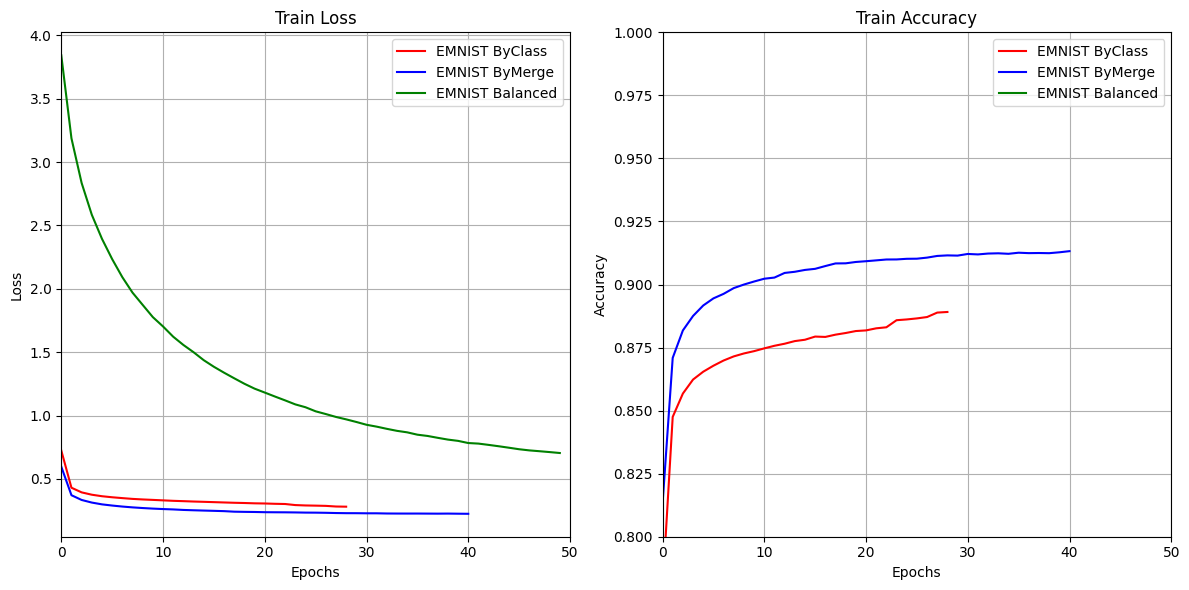

In [50]:
for i, h in zip(range(1, 4), history):
    history_dict = {key: list(map(float, value)) for key, value in h.history.items()}
    save_history(history_dict, f'history_final_{i}_{_time}.json')

colors = ["red", "blue", "green", "purple", "gold", "orange"]

plt.figure(figsize=(12, 6))

plt.subplot(121)
for idx, hist in enumerate(history):
    plt.plot(hist.history['loss'], label=f'{results["Trained Dataset"][idx]}', color=colors[idx])
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend()
plt.subplot(122)
for idx, hist in enumerate(history):
    plt.plot(hist.history['accuracy'], label=f'{results["Trained Dataset"][idx]}', color=colors[idx])
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([0, EPOCHS])
    plt.ylim([0.8, 1])
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.savefig(f"{result_path}/result_final_{_time}.png")
plt.show()

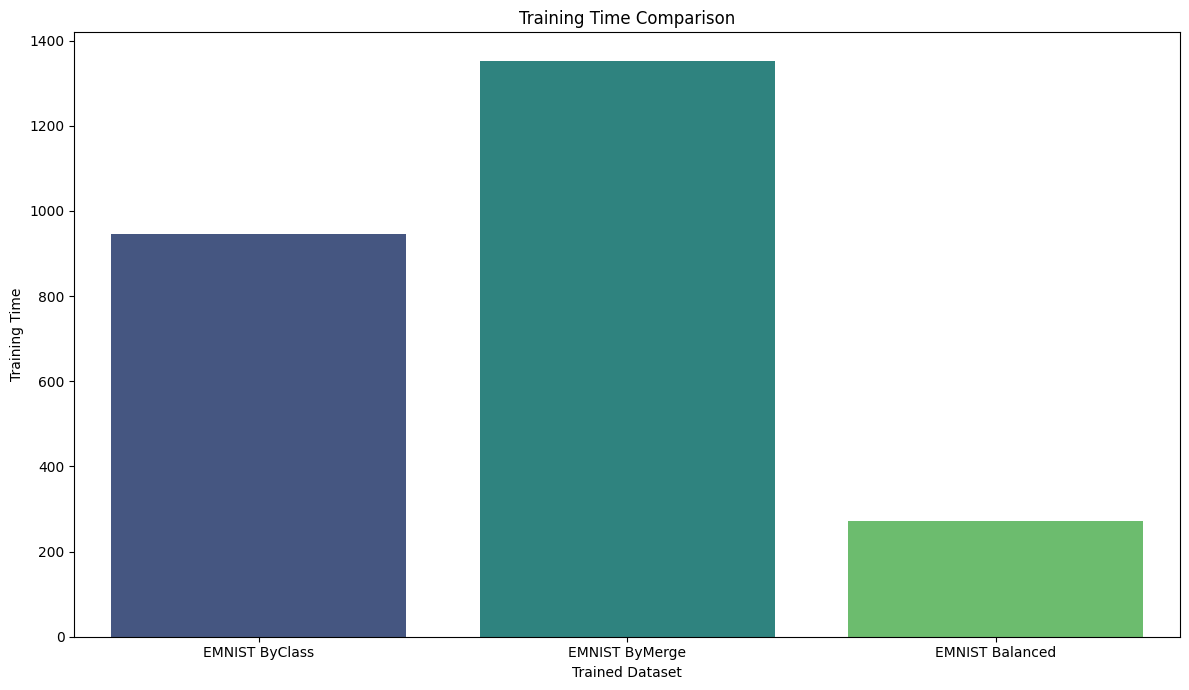

In [51]:
metrics = ["Training Time"]
for metric in metrics:
    plt.figure(figsize=(12, 7))
    sns.barplot(x="Trained Dataset", y=metric, hue="Trained Dataset", data=results_df, palette="viridis", legend=False)
    plt.title(f'{metric} Comparison')
    plt.ylabel(metric)
    plt.xlabel('Trained Dataset')
    plt.tight_layout()
    plt.savefig(f'{result_path}/{metric.lower().replace(" ", "_")}_comparison_final_{_time}.png')
    plt.show()

results = {'Trained Dataset': [], 'Tested Dataset': [], 'Loss': [], 'Accuracy': [], 'F1 Score': []}


class_to_merge = {36: 36, 37: 37, 38: 12, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 18, 45: 19, 46: 20, 47: 21,
                  48: 22, 49: 43, 50: 24, 51: 25, 52: 44, 53: 45, 54: 28, 55: 46, 56: 30, 57: 31, 58: 32, 59: 33, 60: 34, 61: 35}
merge_to_class = {36: 36, 37: 37, 12: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 18: 44, 19: 45, 20: 46, 21: 47,
                  22: 48, 43: 49, 24: 50, 25: 51, 44: 52, 45: 53, 28: 54, 46: 55, 30: 56, 31: 57, 32: 58, 33: 59, 34: 60, 35: 61}

In [52]:
dataset_names = ['EMNIST ByClass', 'EMNIST ByMerge', 'EMNIST Balanced']
models = [model_final_byclass, model_final_bymerge, model_final_balanced]
datasets = [(x_test, y_test_int), (x_test_bymerge, y_test_int_bymerge), (x_test_balanced, y_test_int_balanced)]

In [53]:
def label_transform(label):
    if 0 <= label <= 9:
        return str(label)
    elif 10 <= label <= 35:
        return chr(label + ord('A') - 10)
    elif 36 <= label <= 61:
        return chr(label + ord('a') - 36)
    else:
        return str(label)


def label_transform_merge(label):
    if 0 <= label <= 9:
        return str(label)
    elif label in [10, 11, 13, 14, 15, 16, 17, 23, 26, 27, 29]:
        return chr(label + ord('A') - 10)
    elif 10 <= label <= 35:
        return chr(label + ord('A') - 10) + '/' + chr(label + ord('a') - 10)
    elif label == 36:
        return 'a'
    elif label == 37:
        return 'b'
    elif label == 38:
        return 'd'
    elif label == 39:
        return 'e'
    elif label == 40:
        return 'f'
    elif label == 41:
        return 'g'
    elif label == 42:
        return 'h'
    elif label == 43:
        return 'n'
    elif label == 44:
        return 'q'
    elif label == 45:
        return 'r'
    elif label == 46:
        return 't'
    else:
        return str(label)  # 그 외의 숫자는 그대로 문자열로 반환

In [65]:
results = {'Trained Dataset': [], 'Tested Dataset': [],  'Loss': [], 'Accuracy': [], 'F1 Score': [], }

In [70]:
from sklearn.metrics import accuracy_score, log_loss

588/588 [==============================] - 1s 2ms/step


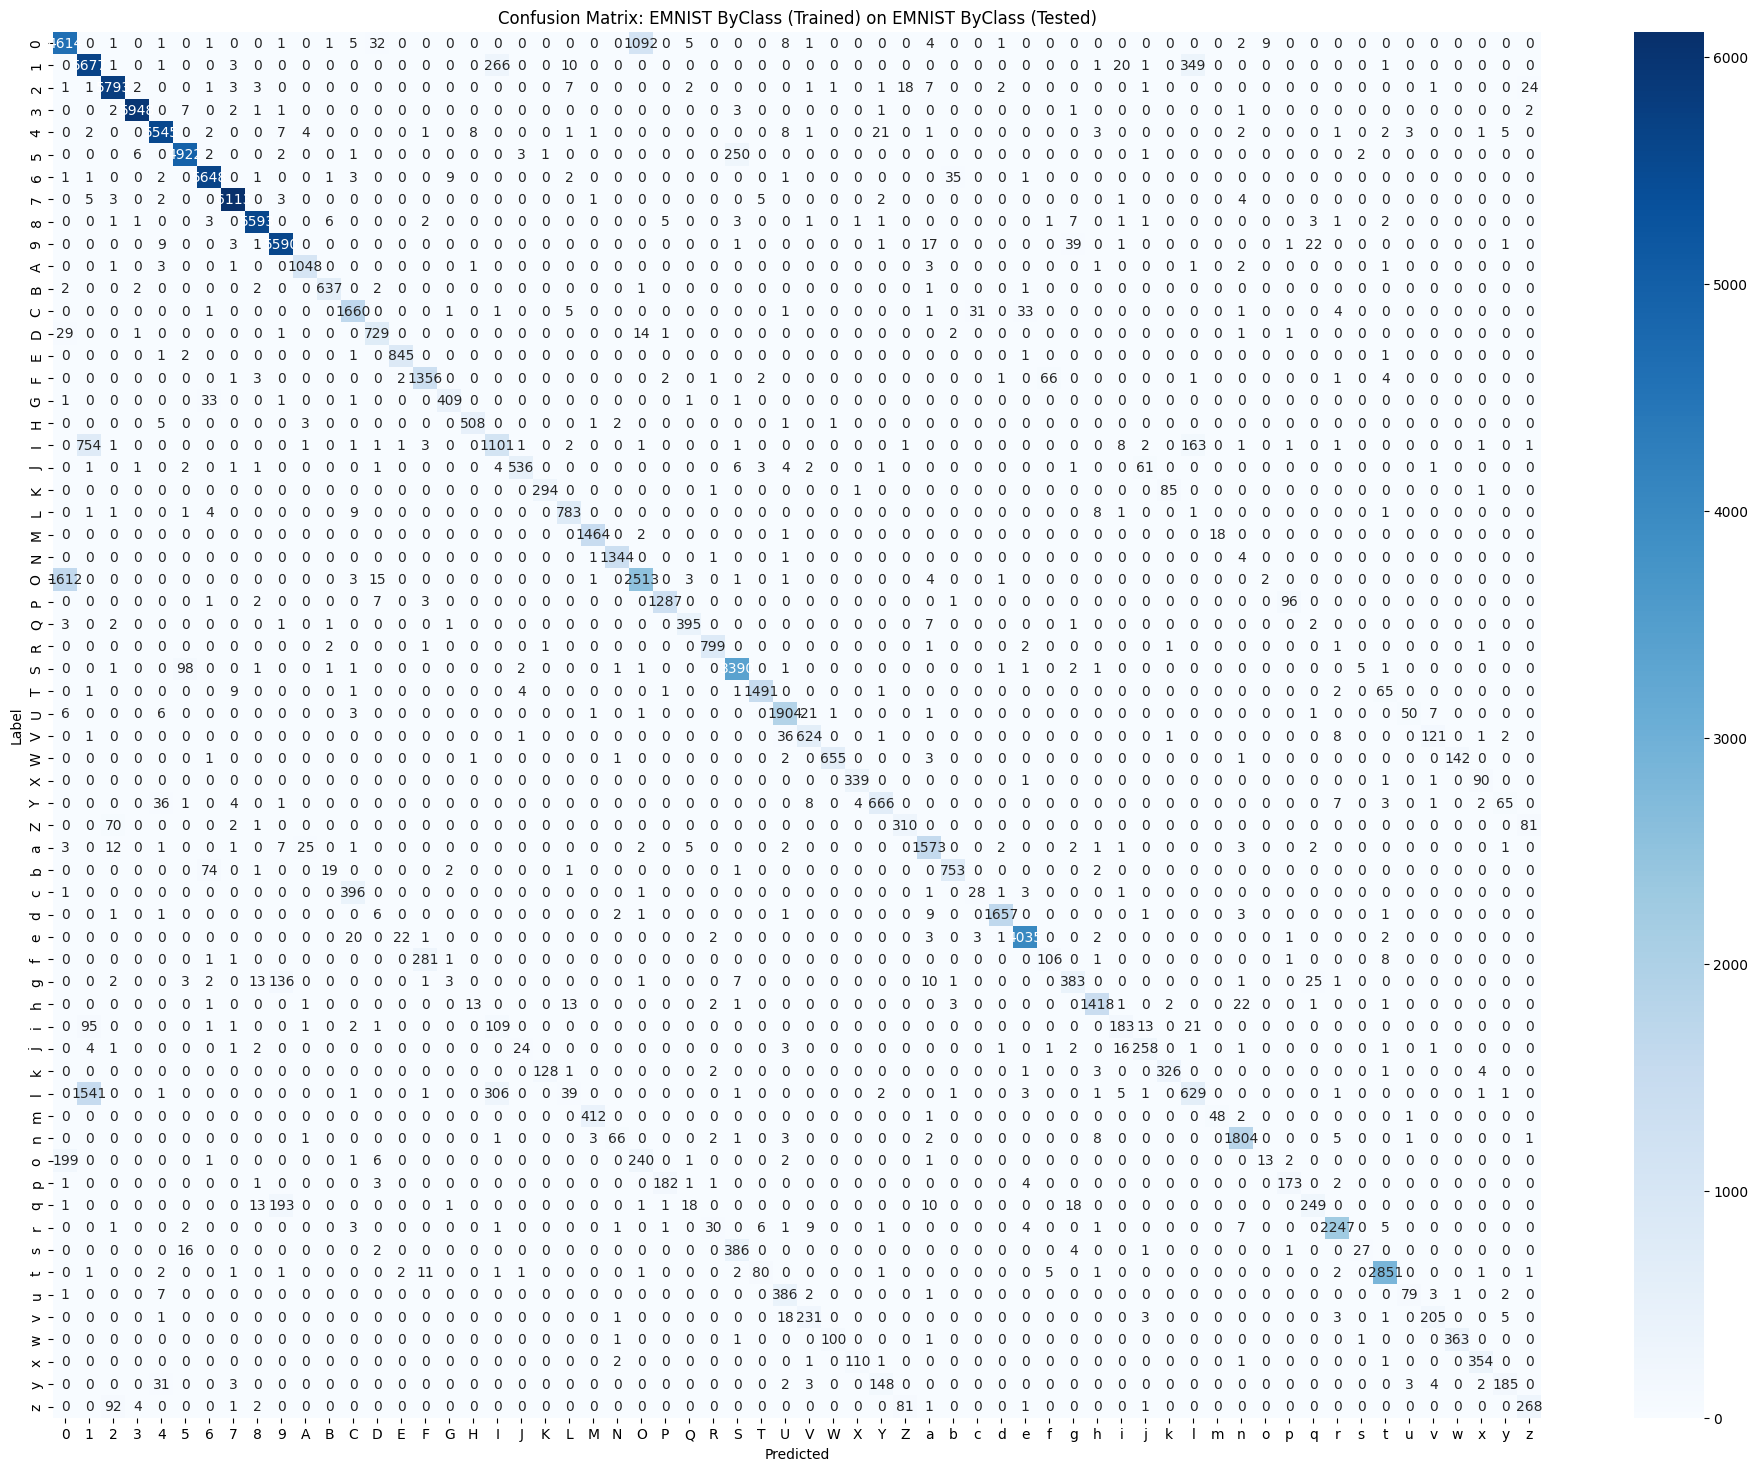

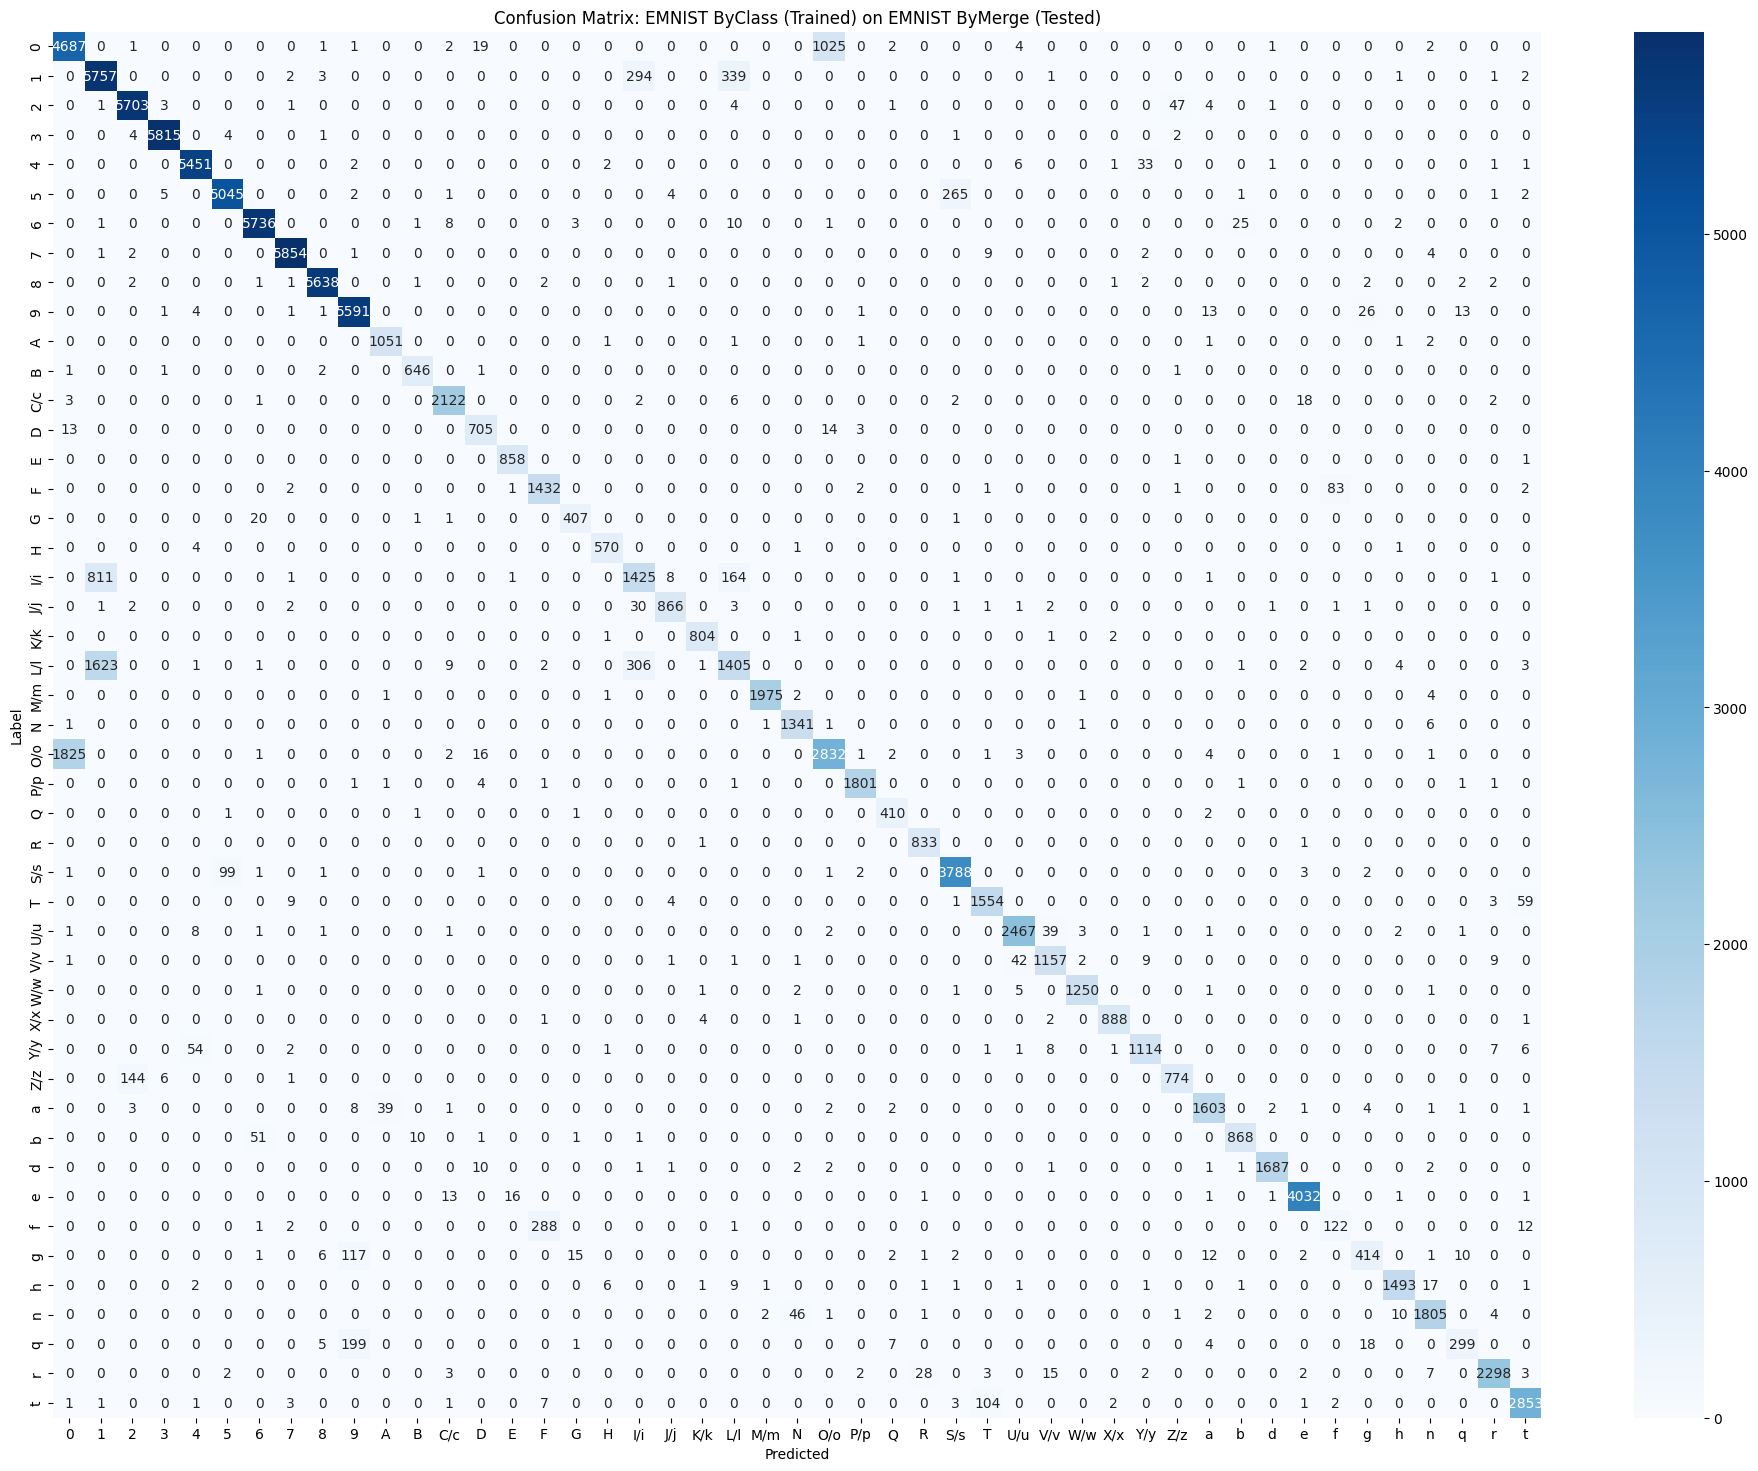

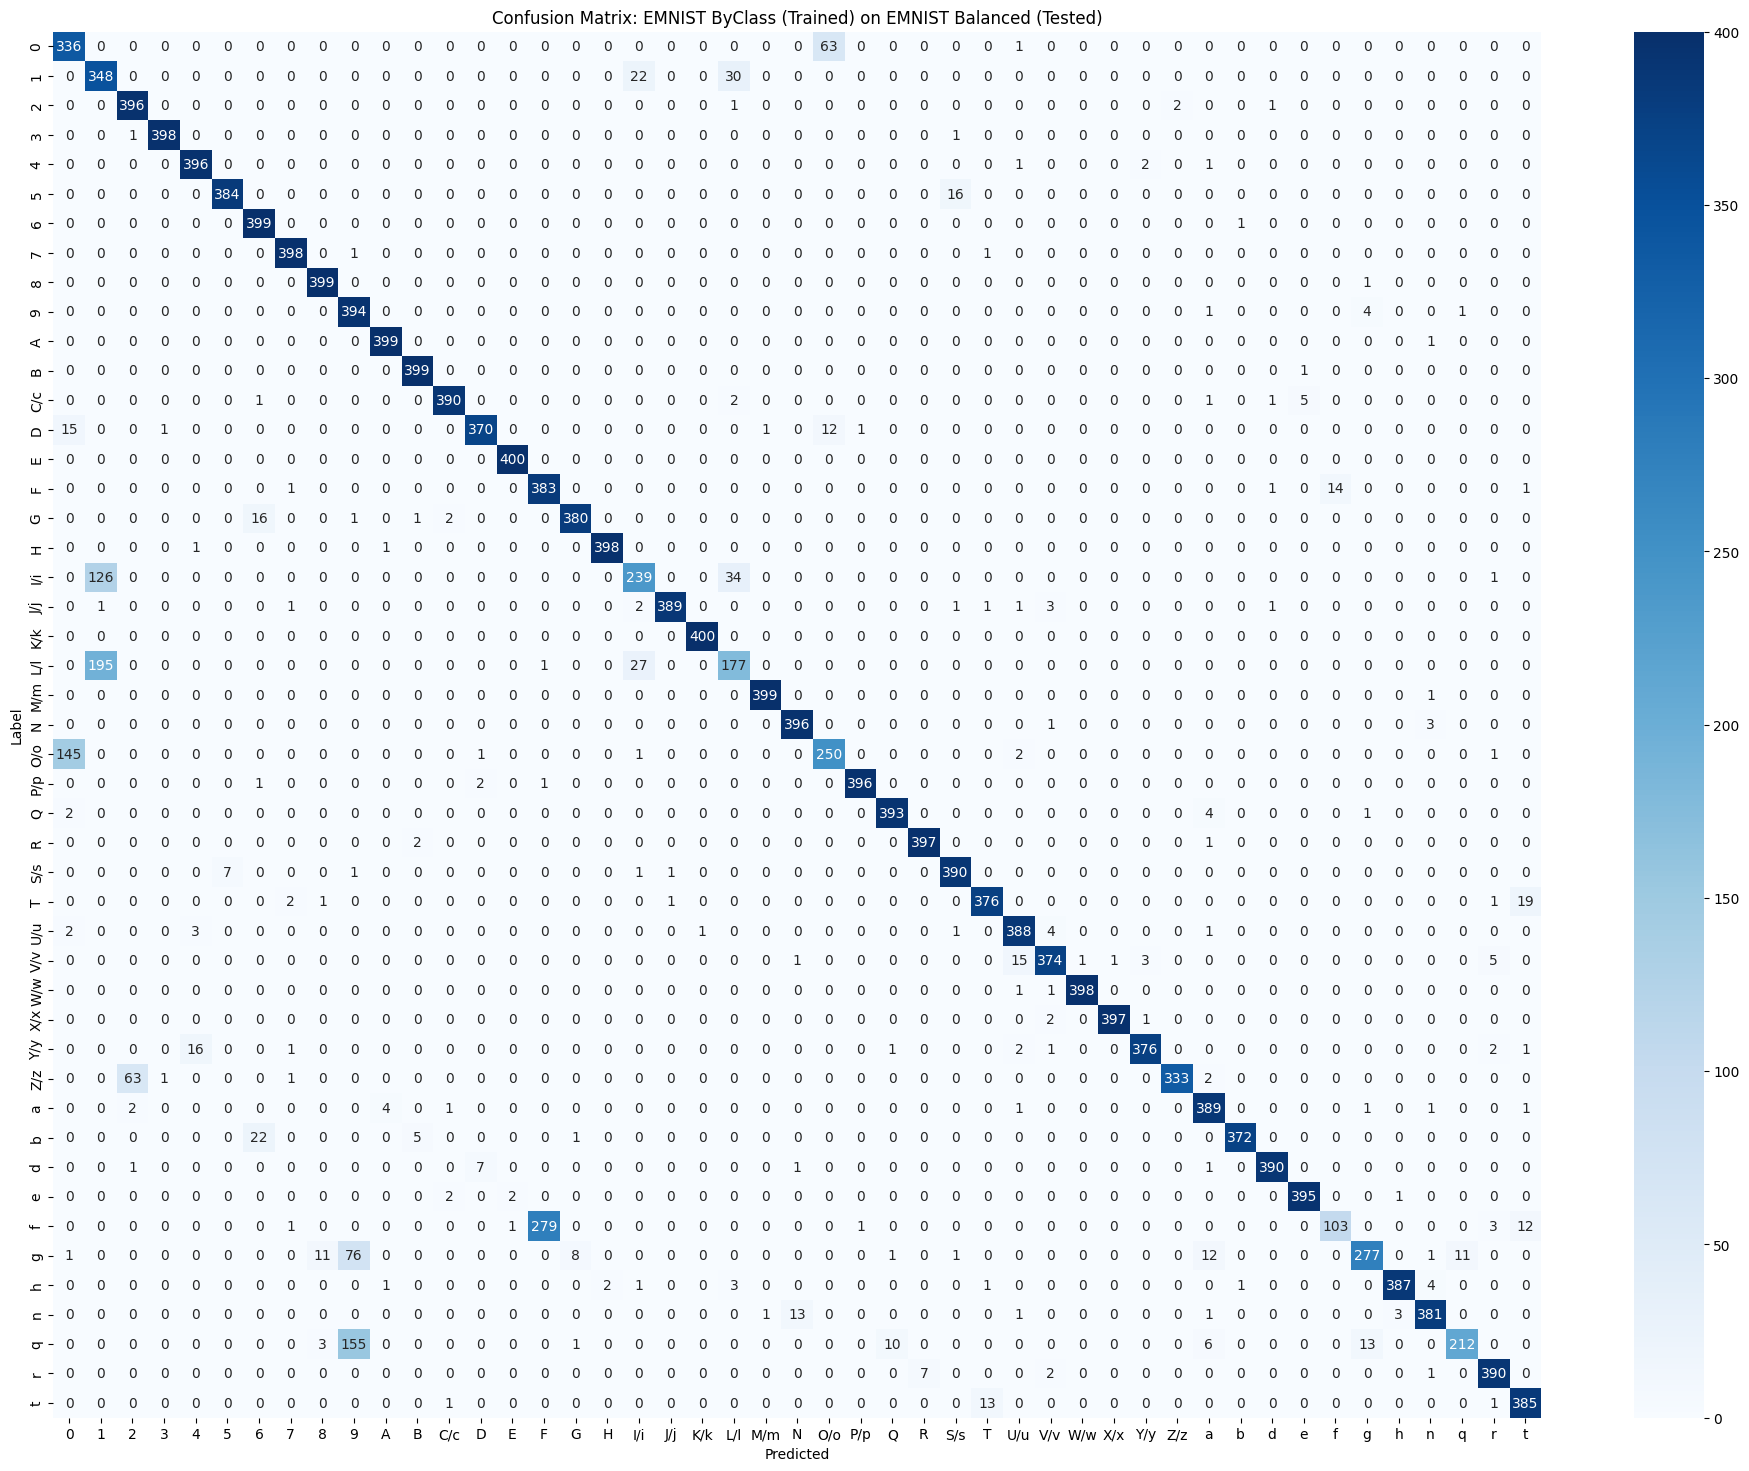

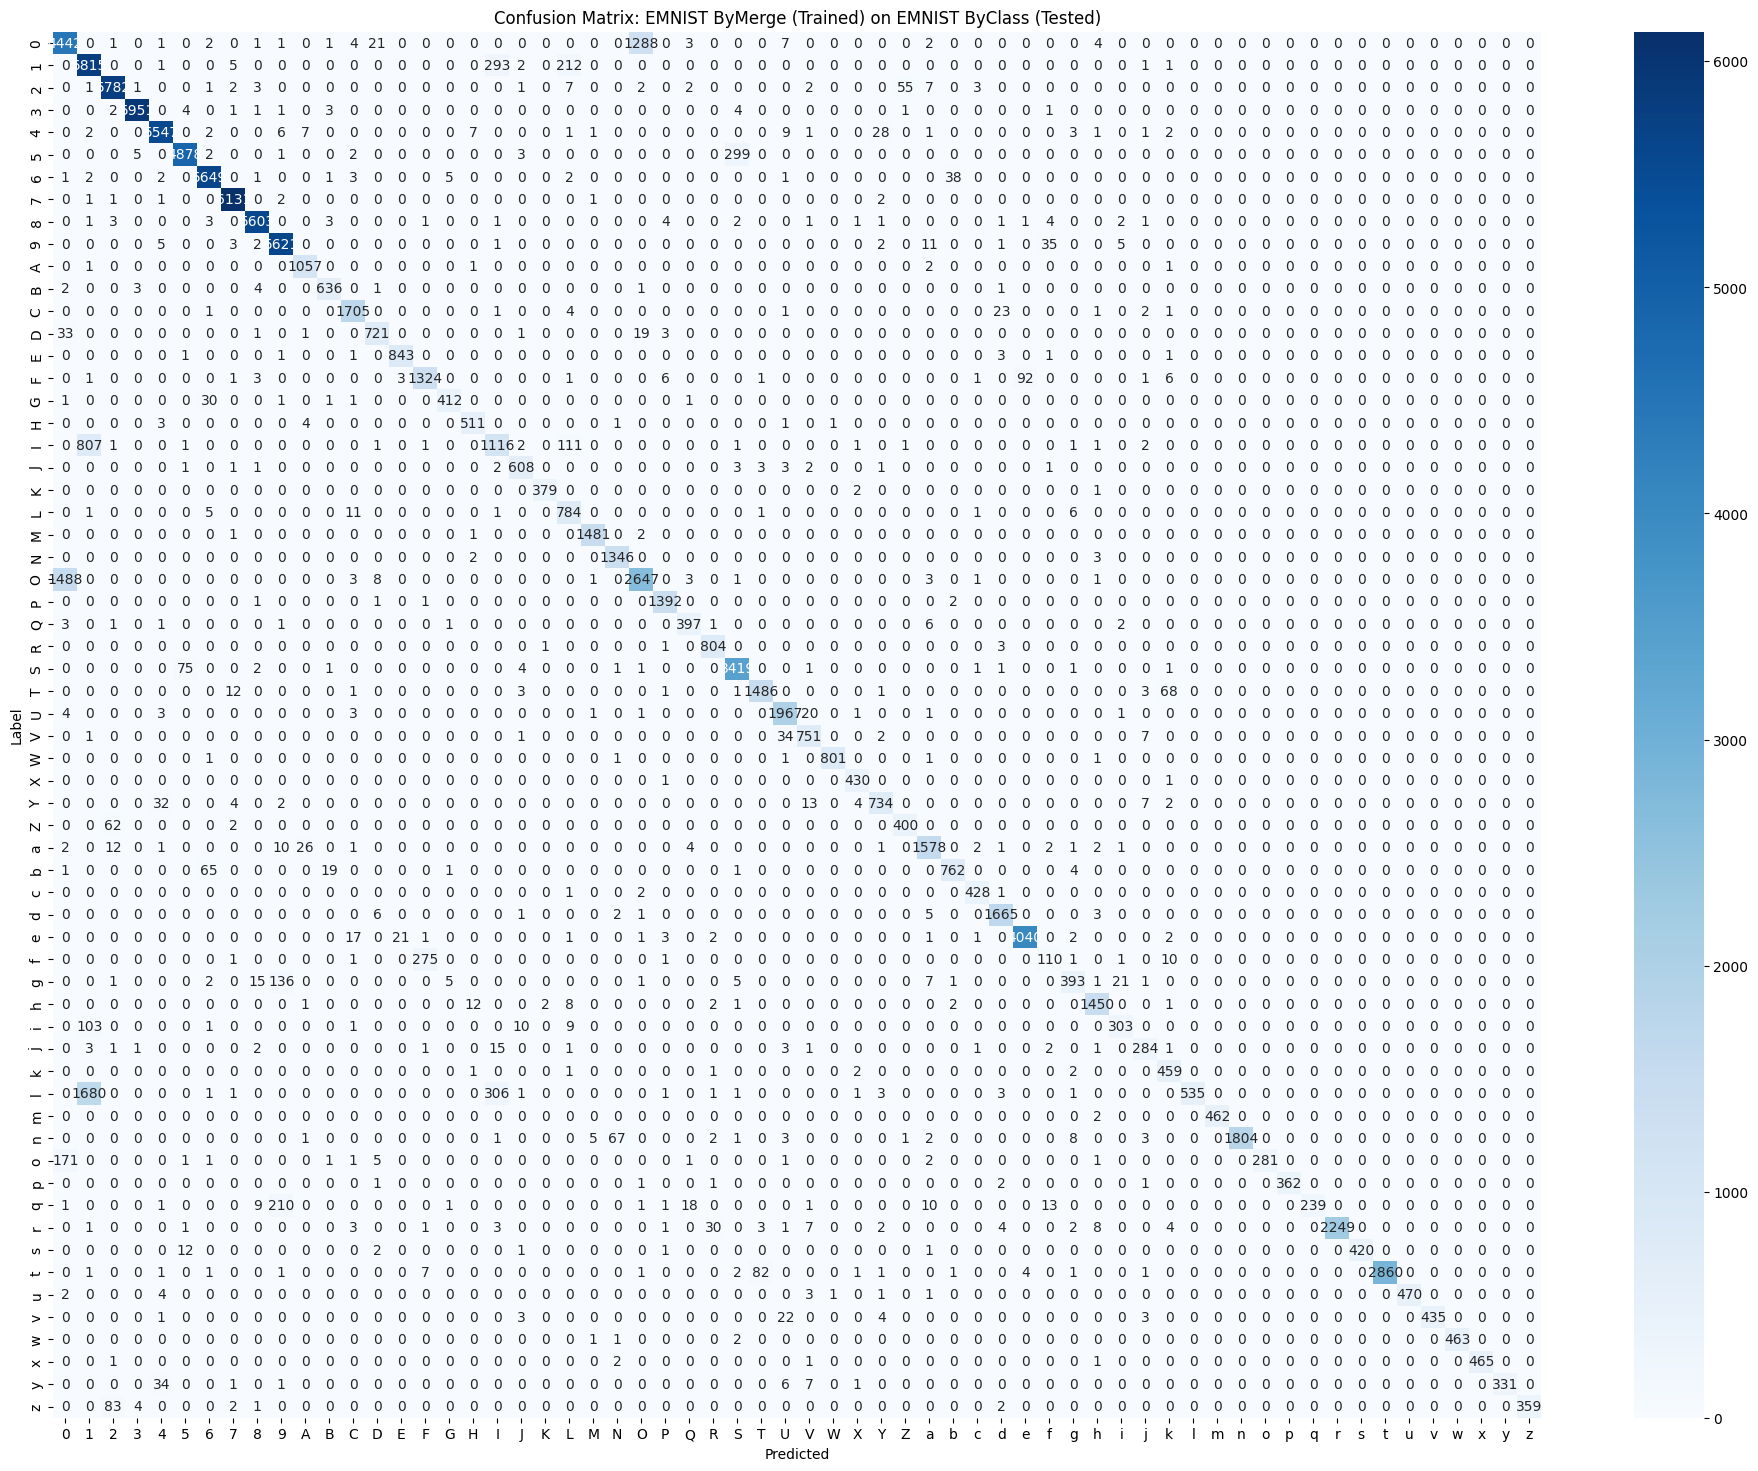

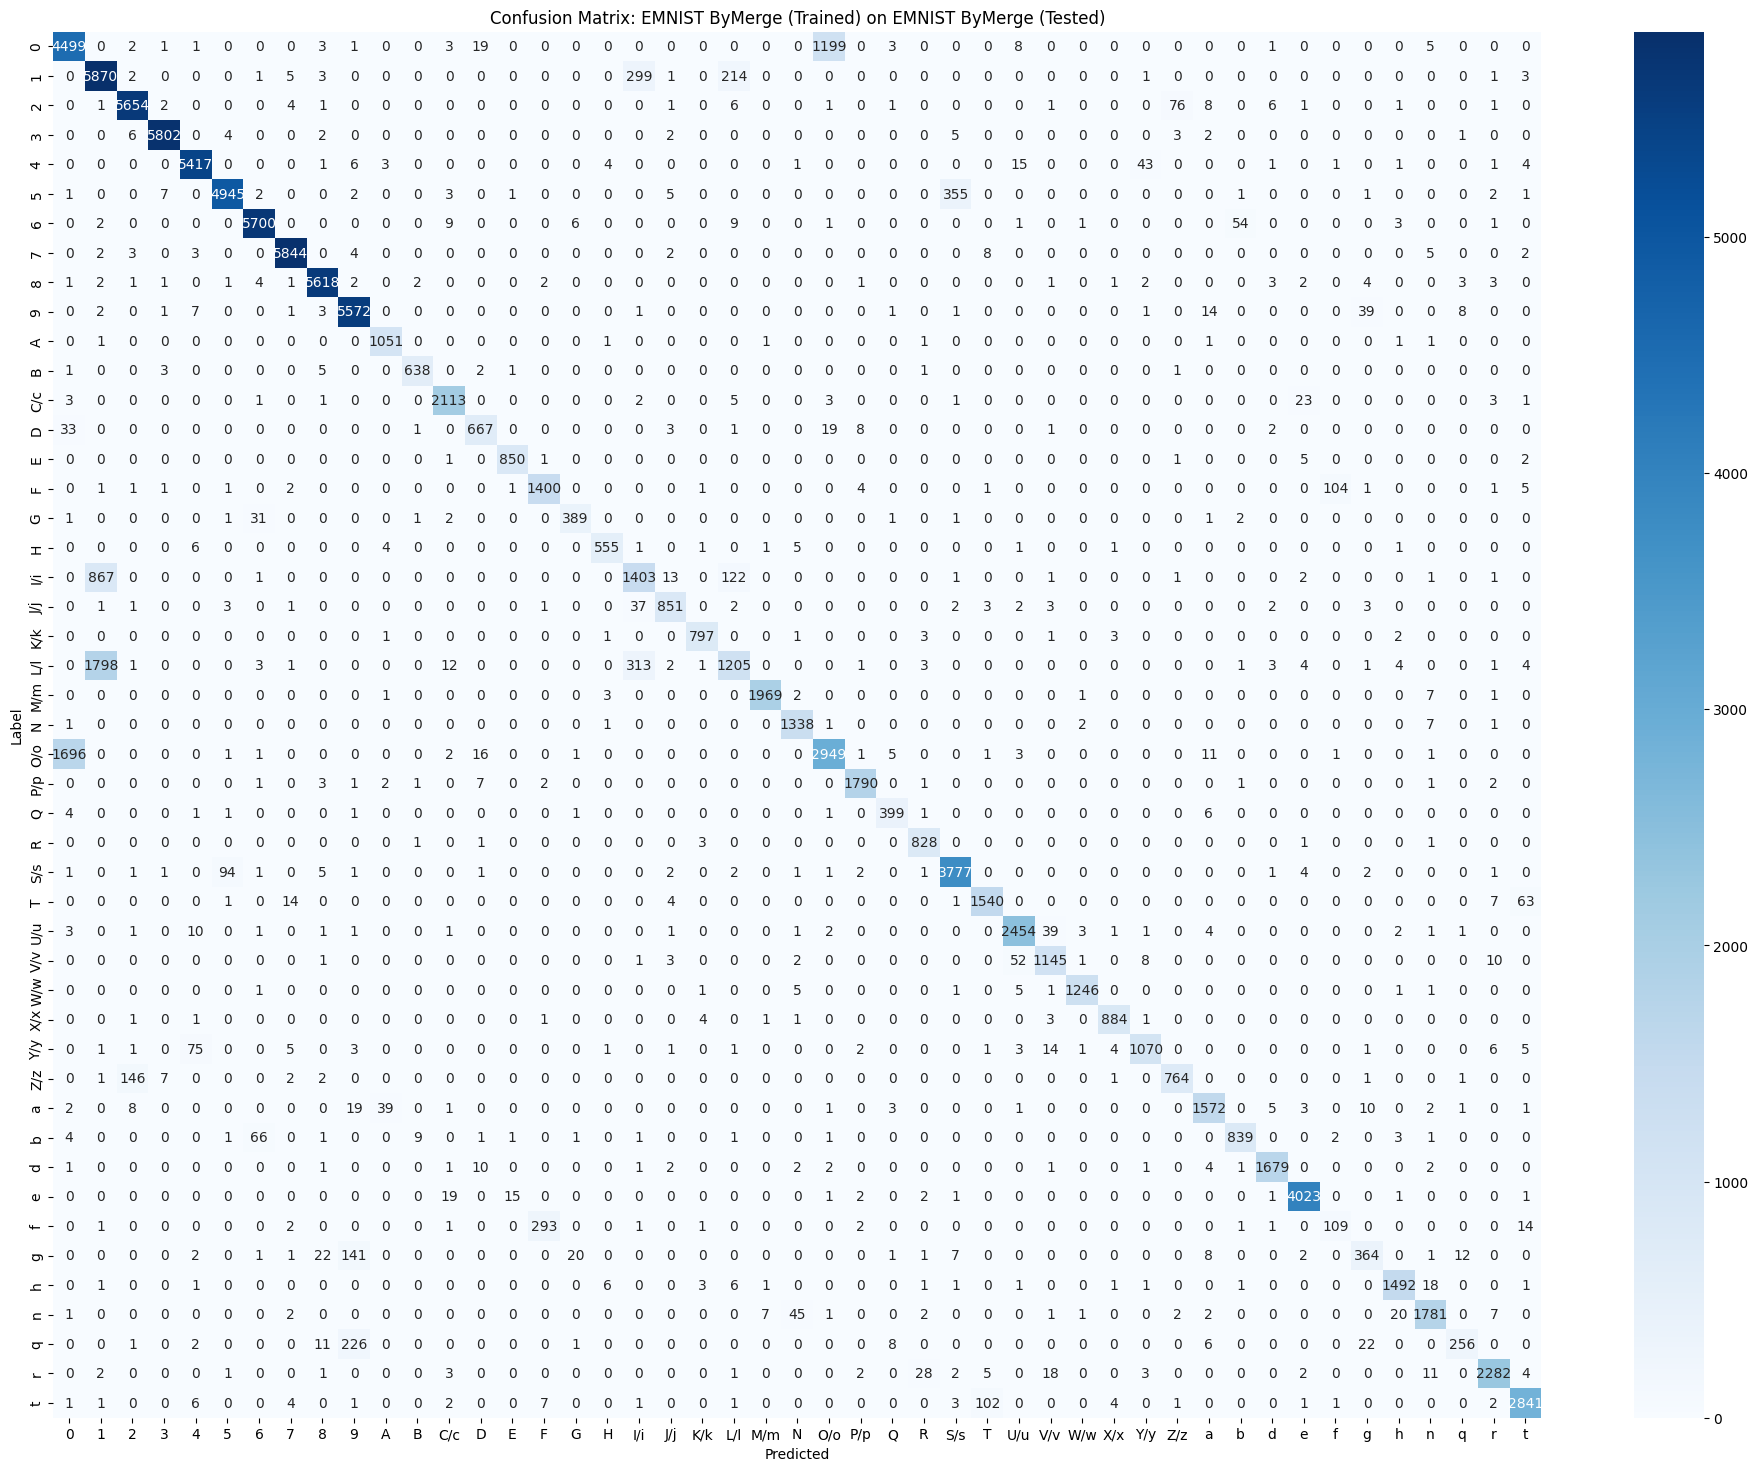

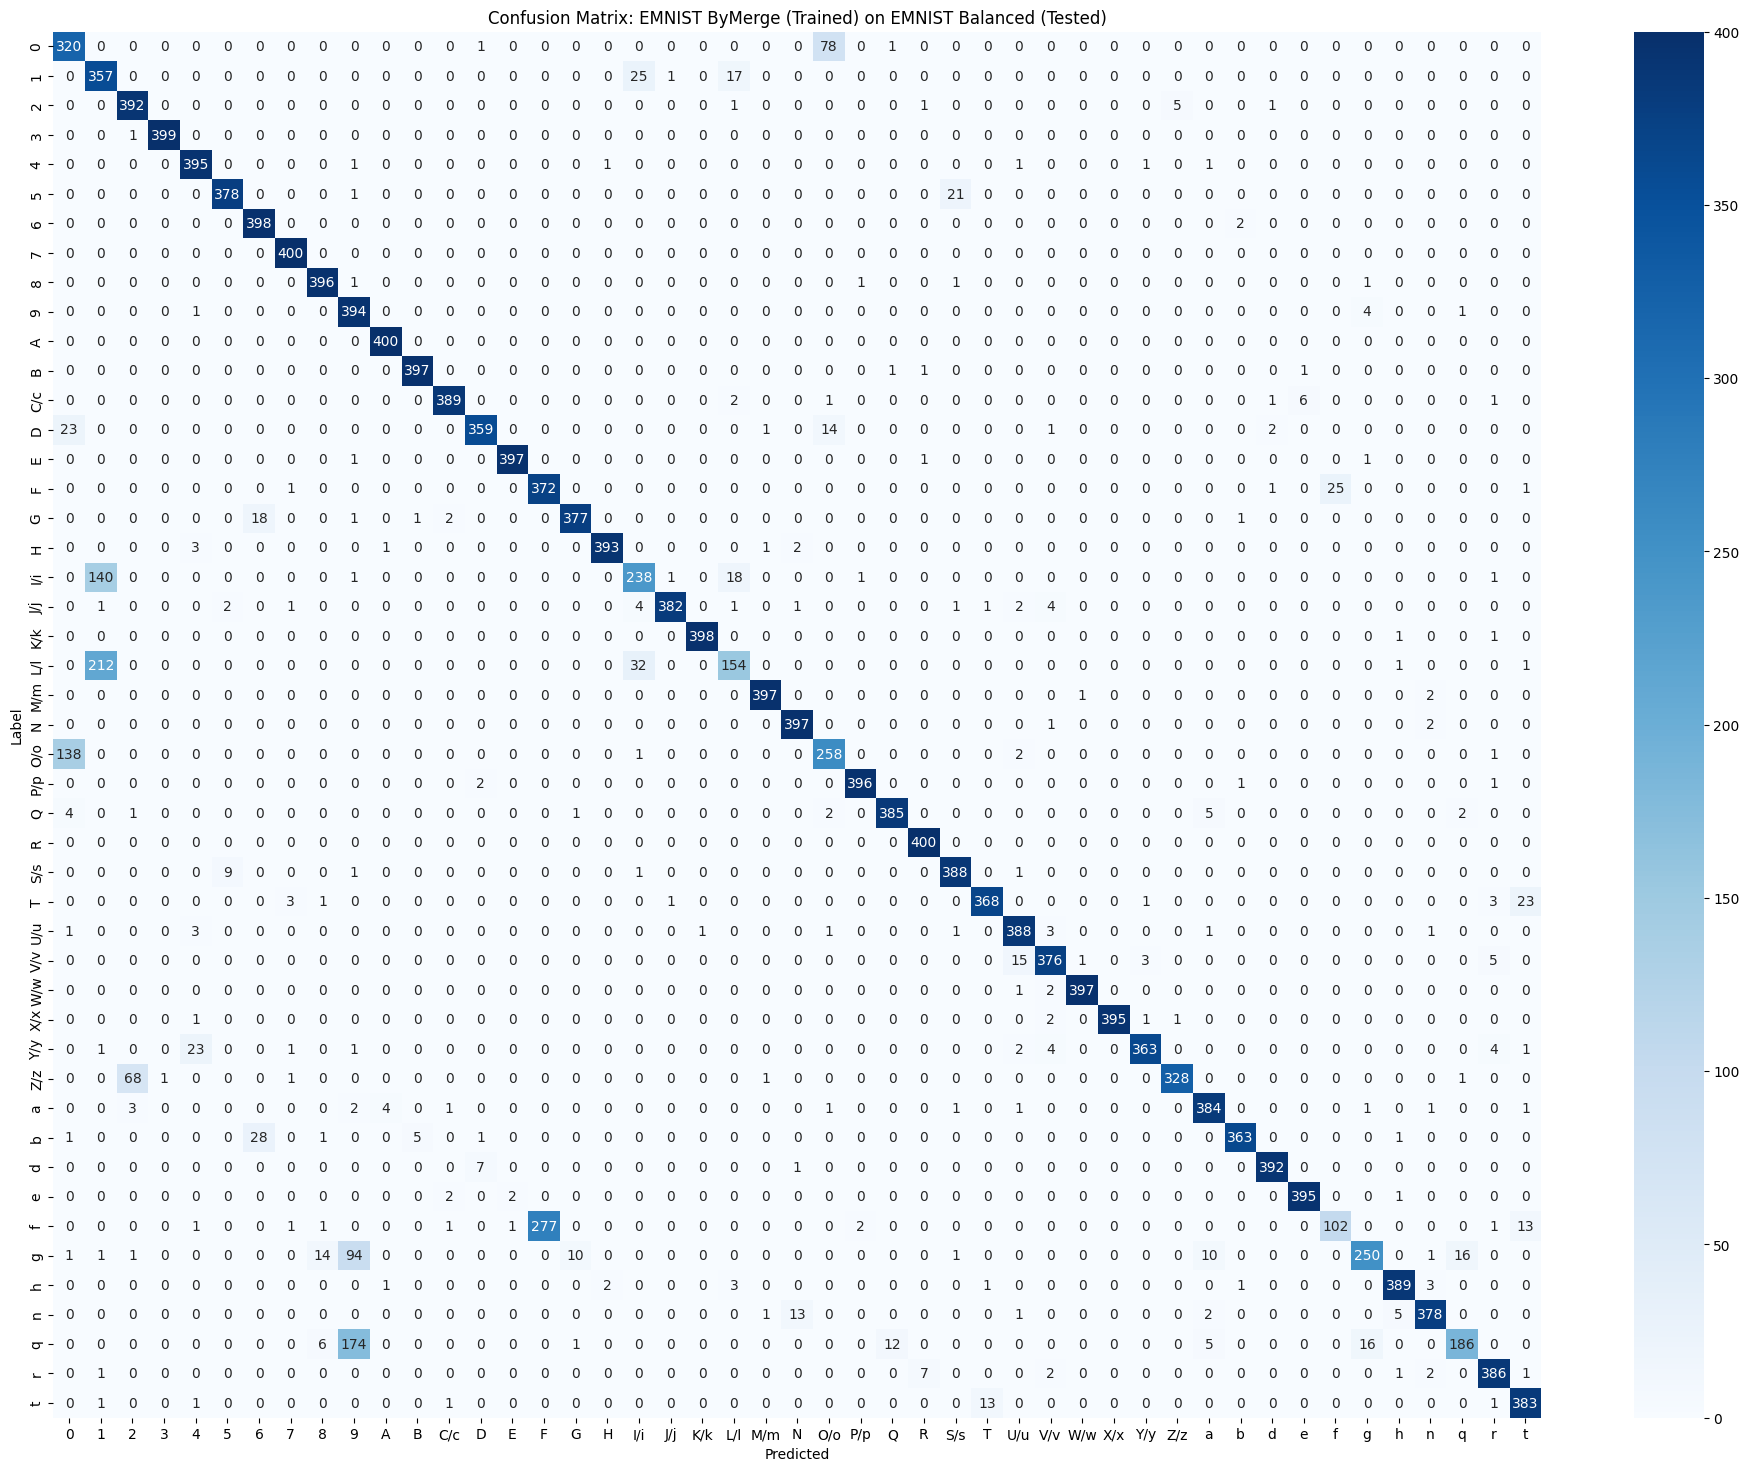

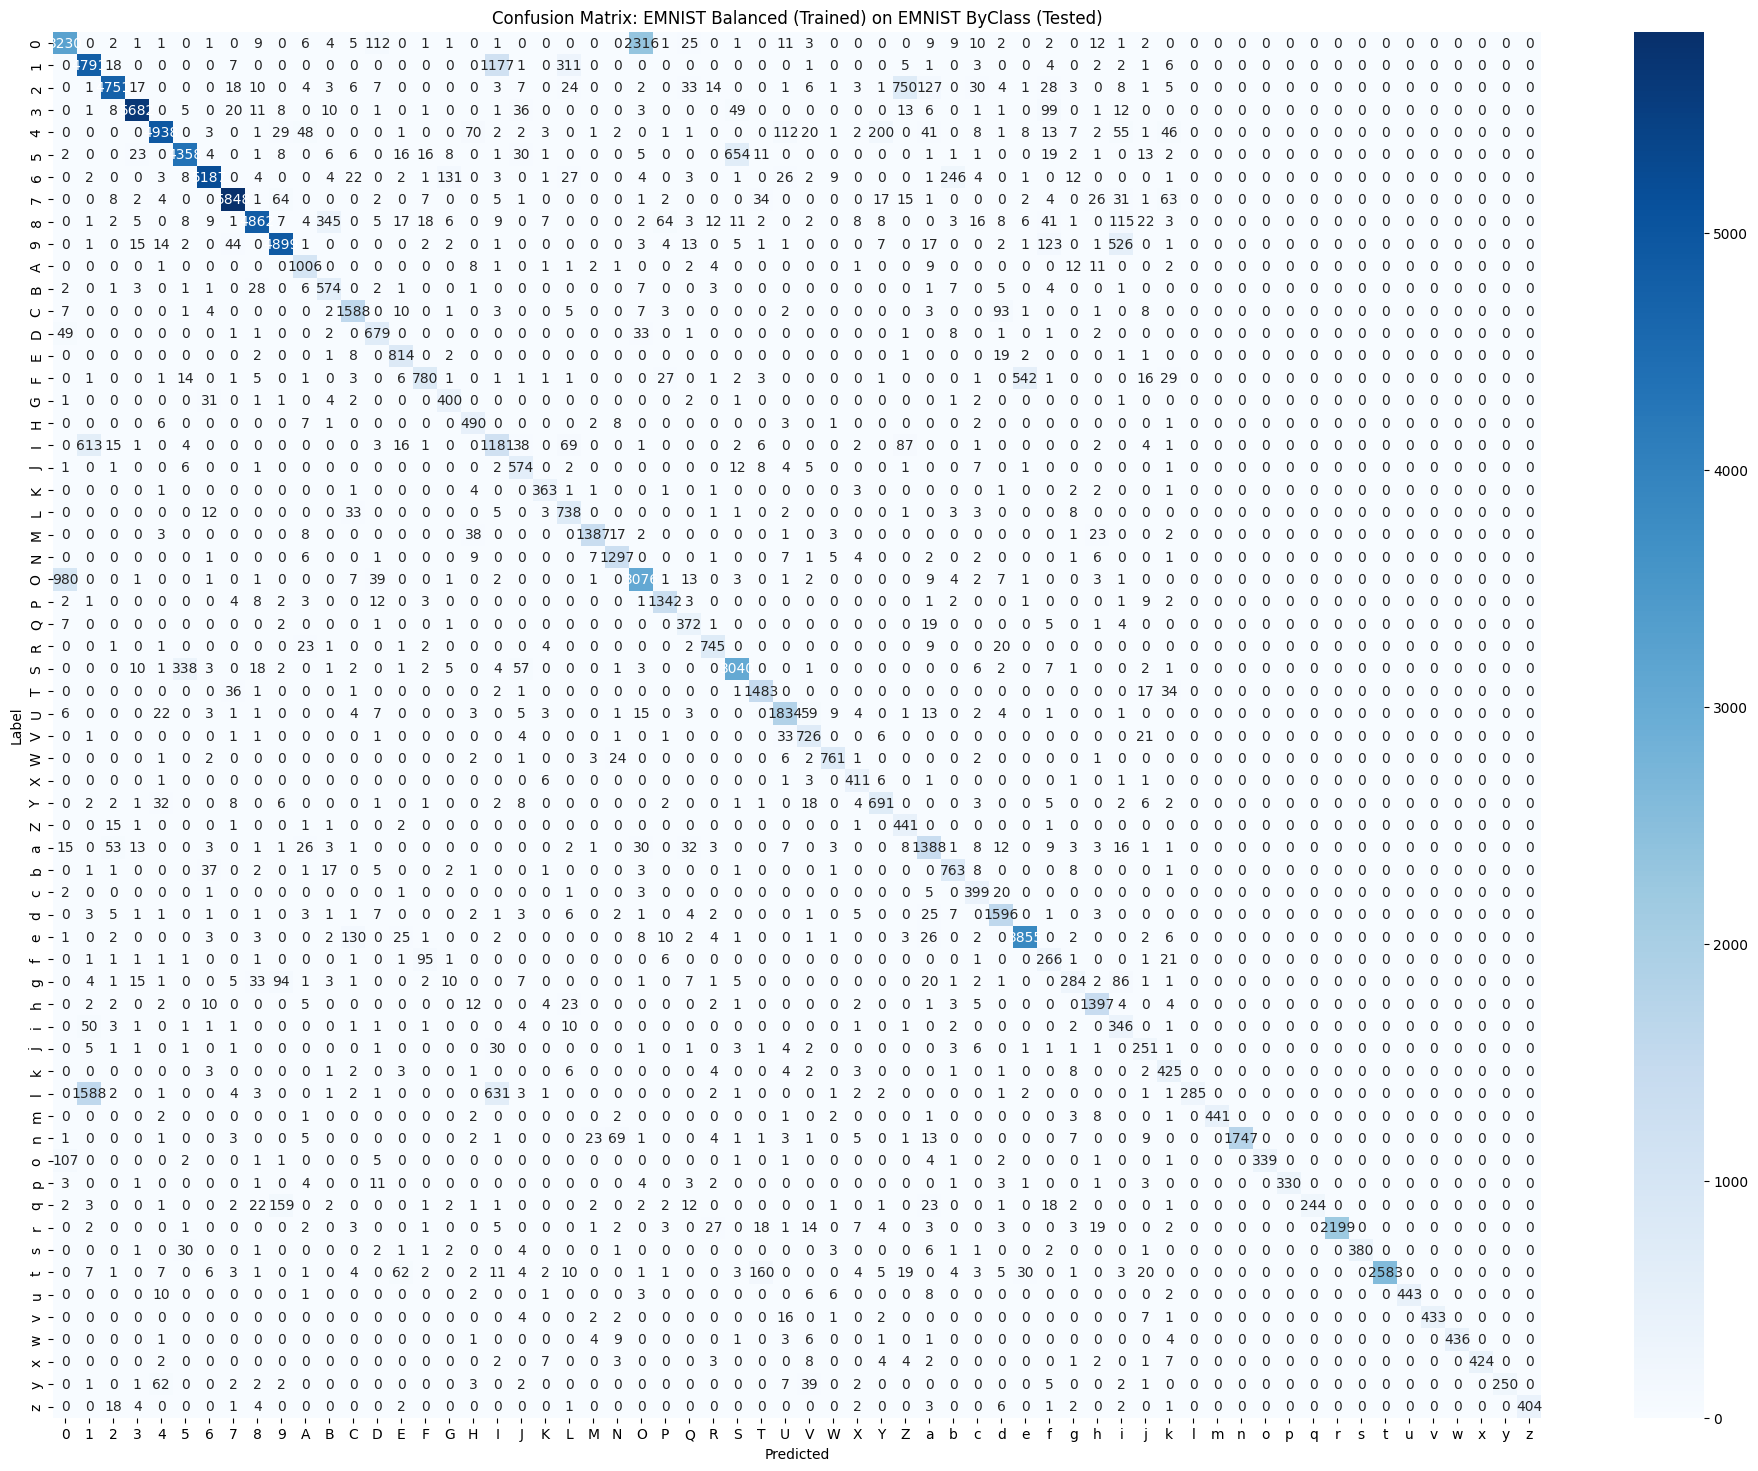

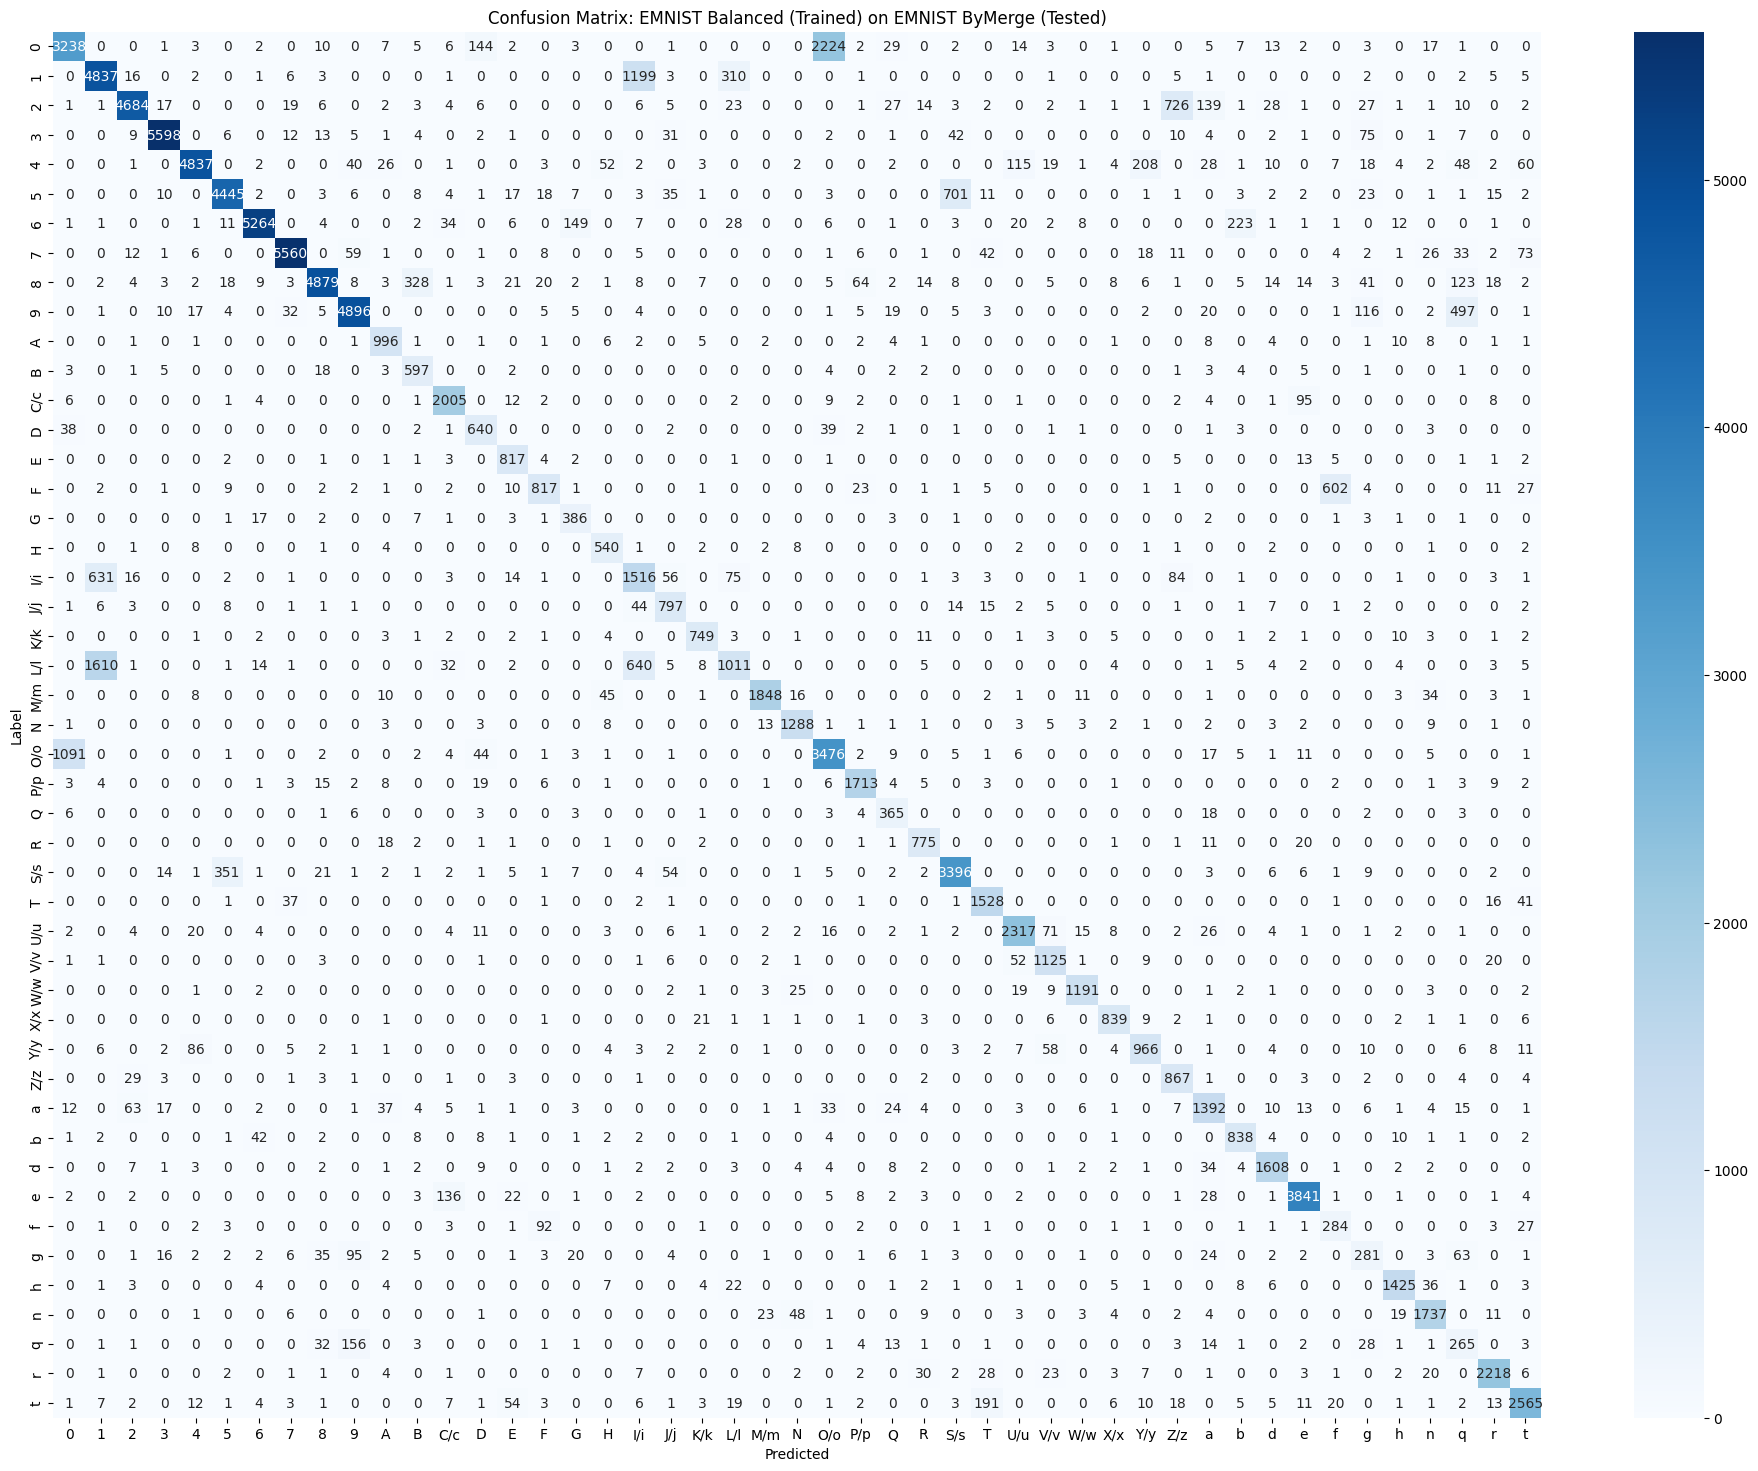

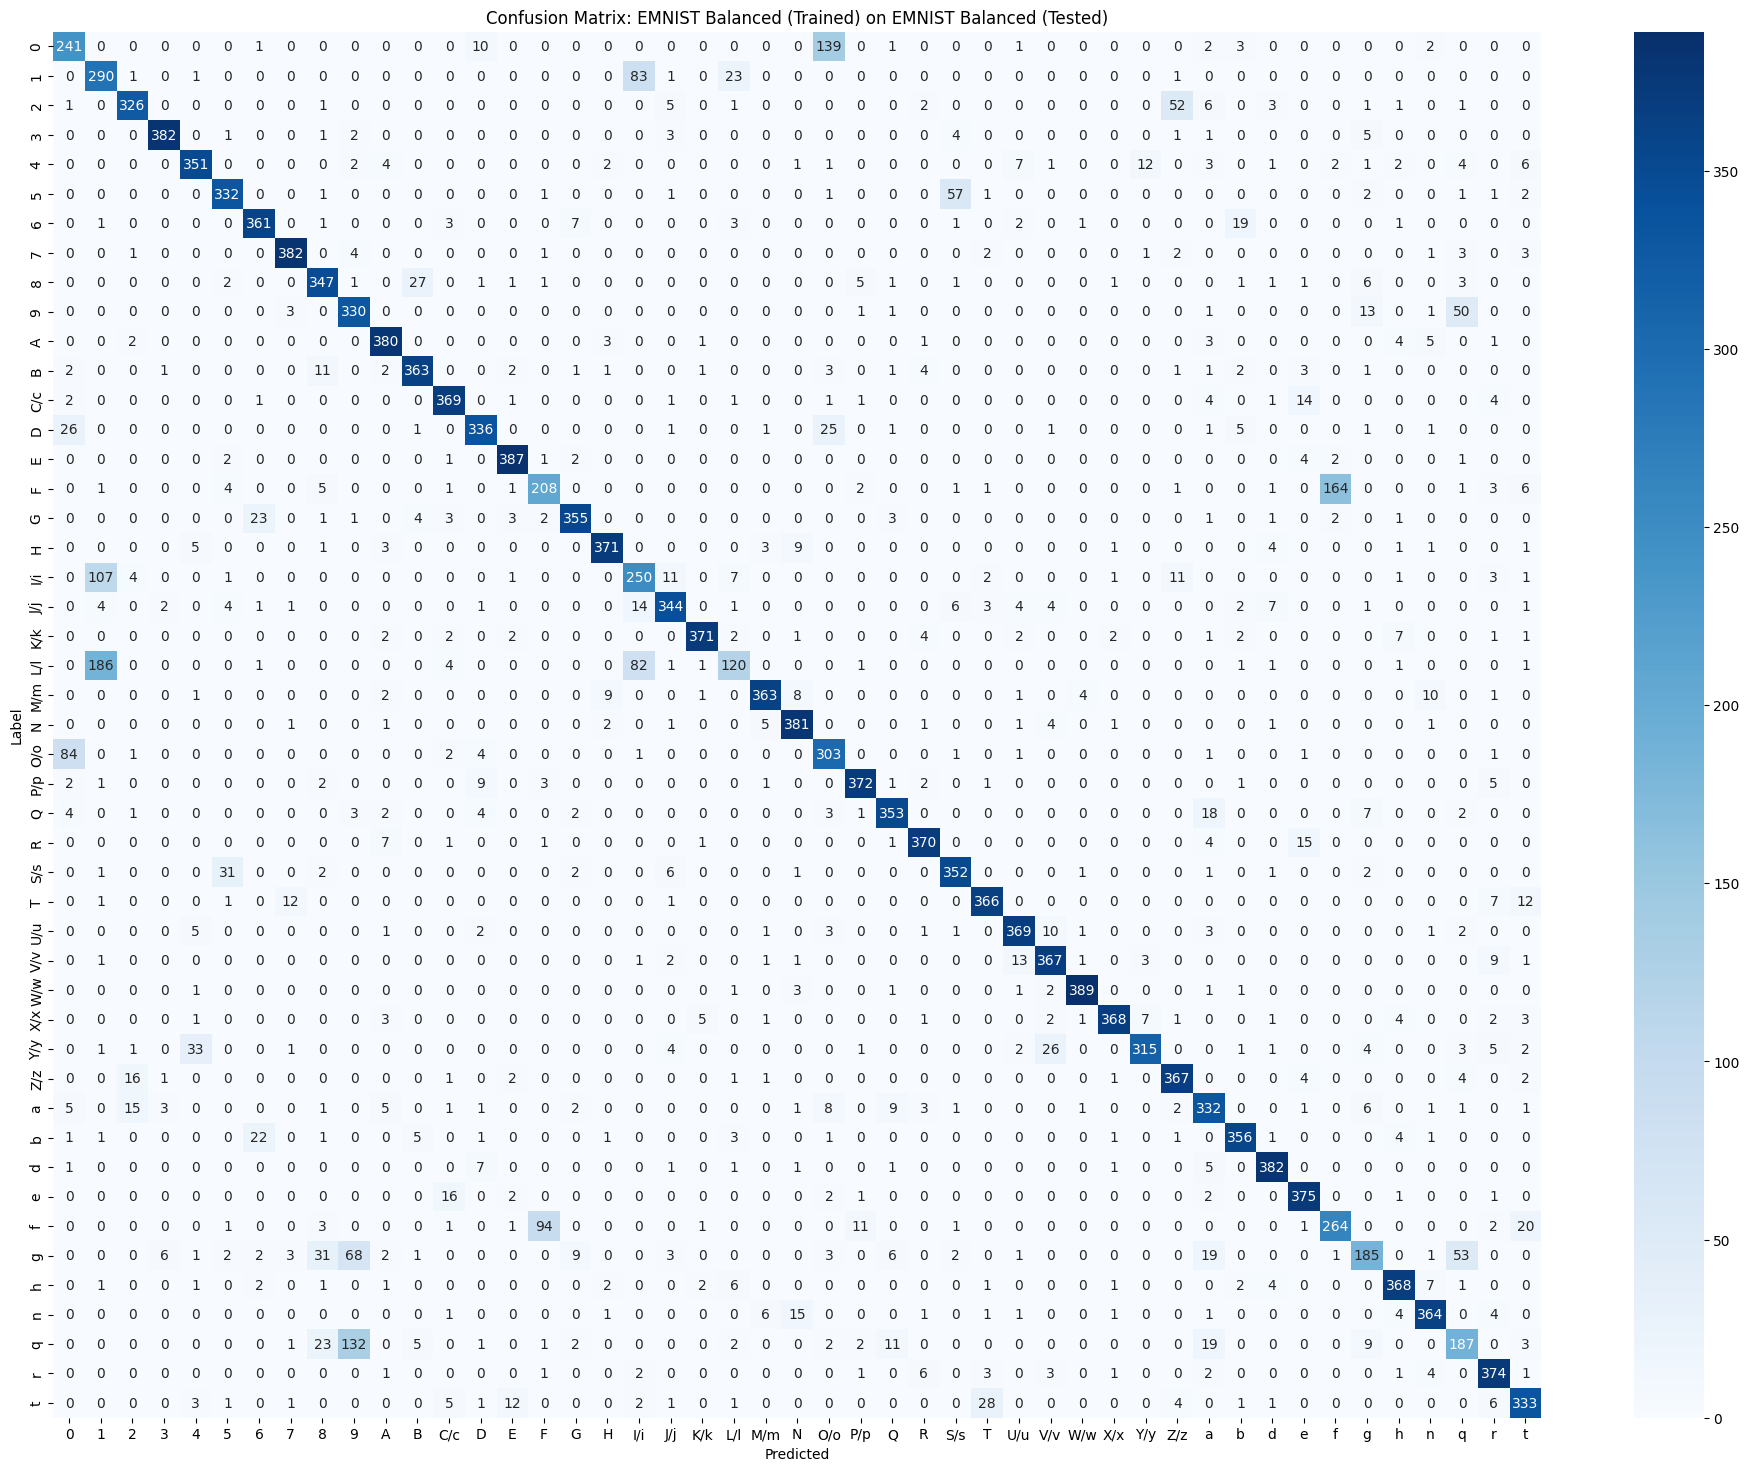

In [72]:
for trained_dataset, model in zip(dataset_names, models):
    for tested_dataset, (x_test_data, y_test_data) in zip(dataset_names, datasets):

        loss, accuracy = model.evaluate(x_test_data, y_test_data)
        y_pred = model.predict(x_test_data).argmax(axis=-1)
        unique_labels = np.unique(y_test_data)
        transformed_labels = []

        if tested_dataset != 'EMNIST ByClass':
            transformed_labels = [label_transform_merge(label) for label in unique_labels]
        else:
            transformed_labels = [label_transform(label) for label in unique_labels]

        if trained_dataset == 'EMNIST ByClass' and tested_dataset != 'EMNIST ByClass':
            y_pred_transformed = [class_to_merge.get(value, value) for value in y_pred]
            y_pred = y_pred_transformed
            accuracy = accuracy_score(y_test_data, y_pred)

        elif trained_dataset != 'EMNIST ByClass' and tested_dataset == 'EMNIST ByClass':
            y_pred_transformed = [merge_to_class[y_pred[i]]
                                  if y_pred[i] in merge_to_class and merge_to_class[y_pred[i]] == y_test_data[i]
                                  else y_pred[i] for i in range(len(y_pred))]
            y_pred = y_pred_transformed
            accuracy = accuracy_score(y_test_data, y_pred)

        cm = confusion_matrix(y_test_data, y_pred)
        transformed_cm = []
        for row in cm:
            transformed_row = [label_transform(label) for label in row]
            transformed_cm.append(transformed_row)

        cm_df = pd.DataFrame(transformed_cm)
        csv_filename = f'{result_path}/{trained_dataset}_to_{tested_dataset}_{_time}.csv'
        cm_df.to_csv(csv_filename, index=False)

        f1 = f1_score(y_test_data, y_pred, average='weighted')

        plt.figure(figsize=(24, 18))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=transformed_labels, yticklabels=transformed_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Label')
        plt.title(f'Confusion Matrix: {trained_dataset} (Trained) on {tested_dataset} (Tested)')
        plt.savefig(f'{result_path}/{trained_dataset}_to_{tested_dataset}_{_time}.png')

        results['Trained Dataset'].append(trained_dataset)
        results['Tested Dataset'].append(tested_dataset)
        results['Loss'].append(loss)
        results['Accuracy'].append(accuracy)
        results['F1 Score'].append(f1)

In [68]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'{result_path}/result_final_{_time}_2.csv', index=False)

In [69]:
results_pivot = results_df.pivot(index='Trained Dataset', columns='Tested Dataset', values='Accuracy')
display(results_pivot)

Tested Dataset,EMNIST Balanced,EMNIST ByClass,EMNIST ByMerge
Trained Dataset,,,
EMNIST Balanced,0.837864,0.836016,0.836102
EMNIST ByClass,0.910474,0.883281,0.921803
EMNIST ByMerge,0.900527,0.917943,0.913249
